# Results Evaluation

In [1]:
%run ../scripts/load_df_for_analysis.py

In [2]:
%run ../scripts/data_visualisations.py

In [3]:
%run ../scripts/df_calculations.py

## Overall model results

### Comparison of best GPT and best Llama Model (from tested models on this data): <br>GPT 4.1 vs. Llama 3.1:70b

In [4]:
chunking = "1024_20"
only_text = True
model = "gpt-4.1-2025-04-14"
df_gpt = load_df_for_analysis(chunking, only_text, model)
results_gpt = eval_predictions(df_gpt, include_relabelled_partially=True)
results_gpt_no_partially = eval_predictions(df_gpt, include_relabelled_partially=False)

AssertionError: Total G (247) should not be 0

In [ ]:
chunking = "256_20"
only_text = True
model = "llama3.1.70b"
df_llama = load_df_for_analysis(chunking, only_text, model)
results_llama = eval_predictions(df_llama, include_relabelled_partially=True)
results_llama_no_partially = eval_predictions(df_llama, include_relabelled_partially=False)

In [ ]:
results_llama_no_partially

{'G (Total)': 233,
 'P (Substantiated)': 126,
 'N (Unsubstantiated)': 107,
 'TP': 95,
 'FP': 8,
 'TN': 99,
 'FN': 31,
 'accuracy': 0.833,
 'precision': 0.922,
 'recall': 0.754,
 'specificity': 0.925,
 'f1_score': 0.83,
 'invalid_labels': {'Unsubstantiated': [], 'Substantiated': []}}

In [ ]:
model_results = {
    "GPT-4.1": results_gpt,
    "Llama 3.1:70b": results_llama,
}

model_results_no_partially = {
    "GPT-4.1": results_gpt_no_partially,
    "Llama 3.1:70b": results_llama_no_partially
}

display_model_results_table(model_results)
display_model_results_table(model_results_no_partially)

,Accuracy,Precision,Recall,Specificity,F1_score
Model,,,,,
GPT-4.1,0.858,0.844,0.902,0.809,0.872
Llama 3.1:70b,0.822,0.893,0.758,0.896,0.820


,Accuracy,Precision,Recall,Specificity,F1_score
Model,,,,,
GPT-4.1,0.876,0.865,0.913,0.832,0.888
Llama 3.1:70b,0.833,0.922,0.754,0.925,0.830


In [ ]:
preds_results = {
    "GPT-4.1": get_preds_results(results_gpt),
    "Llama 3.1:70b": get_preds_results(results_llama)
}

preds_results_no_partially = {
    "GPT-4.1": get_preds_results(results_gpt_no_partially),
    "Llama 3.1:70b": get_preds_results(results_llama_no_partially)
}

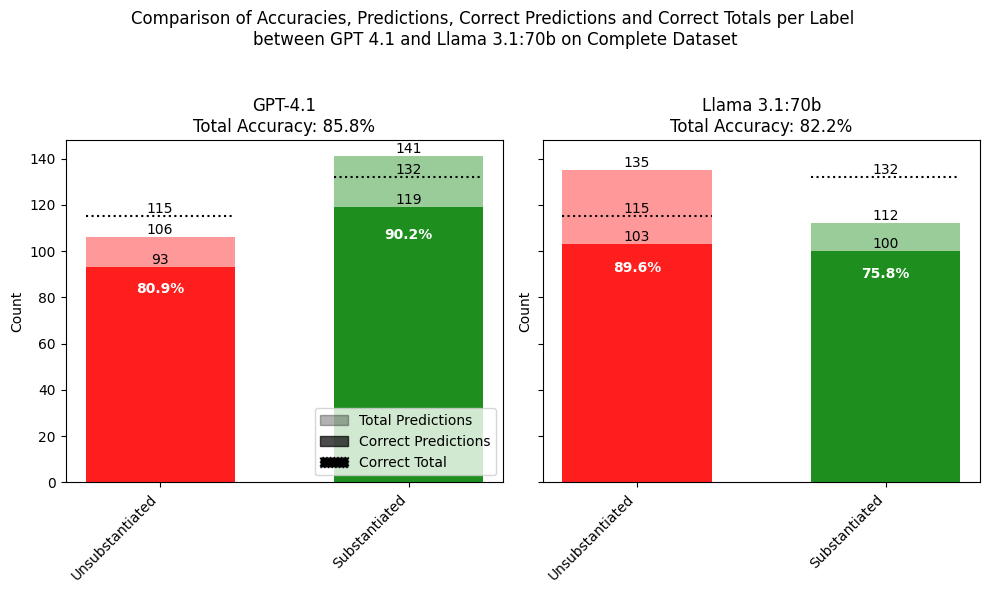

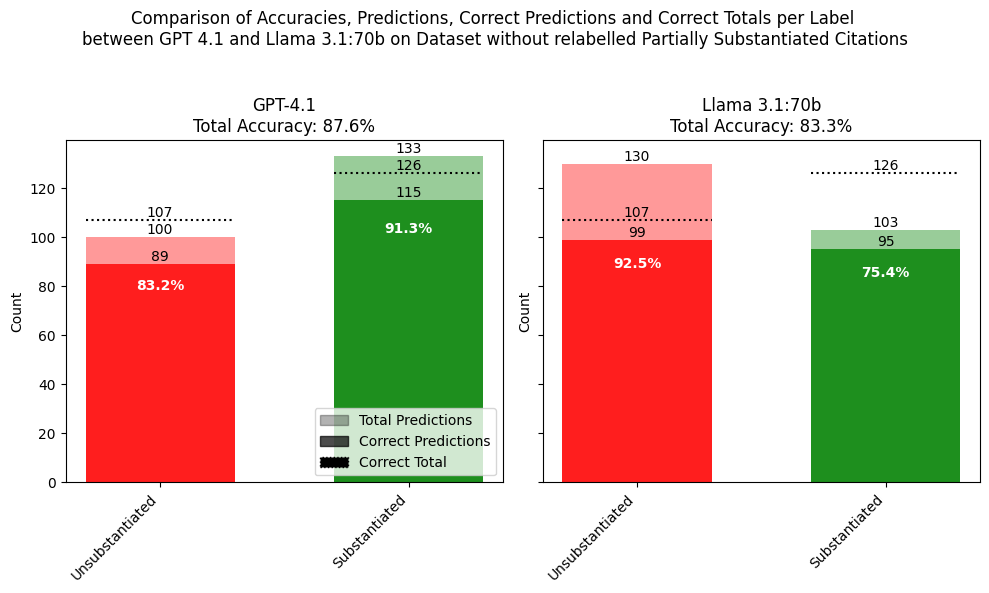

In [ ]:
title = "Comparison of Accuracies, Predictions, Correct Predictions and Correct Totals per Label \nbetween GPT 4.1 and Llama 3.1:70b on Complete Dataset"
show_preds_vs_correct_preds_vs_total(list(preds_results.values()), list(preds_results.keys()), title=title, labels=['Unsubstantiated', 'Substantiated'], smaller_figures=True)

title = "Comparison of Accuracies, Predictions, Correct Predictions and Correct Totals per Label \nbetween GPT 4.1 and Llama 3.1:70b on Dataset without relabelled Partially Substantiated Citations"
show_preds_vs_correct_preds_vs_total(list(preds_results_no_partially.values()), list(preds_results.keys()), title=title, labels=['Unsubstantiated', 'Substantiated'], smaller_figures=True)

## Comparison: Evaluation per Annotation Attribute

In [ ]:
def attribute_predictions_per_model(model_dfs, attribute):
    results = {}
    for model_name, df in model_dfs.items():
        results[model_name] = eval_predictions_per_attribute_value(df, attribute, include_relabelled_partially=True)
        results[model_name + " (exclude relabelled partially)"] = eval_predictions_per_attribute_value(df, attribute, include_relabelled_partially=False)
    return results

In [ ]:
model_dfs = {
    "GPT-4.1": df_gpt,
    "Llama 3.1:70b": df_llama
}

### Reference Only

In [ ]:
attribute = "Reference Only"
results = attribute_predictions_per_model(model_dfs, attribute)
display_attribute_results_table(results, attribute, use_pandas=True)
display_attribute_differences_to_total_table(results, attribute, use_pandas=True)

Results for attribute 'Reference Only':


,Total,"""Yes""","""No"""
Model,,,
GPT-4.1,85.8%,89.9%,84.3%
GPT-4.1 (exclude relabelled partially),87.6%,92.3%,85.7%
Llama 3.1:70b,82.2%,81.2%,82.6%
Llama 3.1:70b (exclude relabelled partially),83.3%,81.5%,83.9%


Differences to Total for attribute 'Reference Only' (positive = better than total):


,"""Yes""","""No"""
Model,,
GPT-4.1,+4.1%,-1.5%
GPT-4.1 (exclude relabelled partially),+4.7%,-1.9%
Llama 3.1:70b,-1.0%,+0.4%
Llama 3.1:70b (exclude relabelled partially),-1.8%,+0.6%


### Claim Contains Number or Formula

In [ ]:
attribute = "Claim Contains Number or Formula"
results = attribute_predictions_per_model(model_dfs, attribute)
display_attribute_results_table(results, attribute, use_pandas=True)
display_attribute_differences_to_total_table(results, attribute, use_pandas=True)

Results for attribute 'Claim Contains Number or Formula':


,Total,"""No""","""Number""","""Formula"""
Model,,,,
GPT-4.1,85.8%,87.4%,76.5%,83.3%
GPT-4.1 (exclude relabelled partially),87.6%,88.4%,82.8%,83.3%
Llama 3.1:70b,82.2%,84.1%,70.6%,83.3%
Llama 3.1:70b (exclude relabelled partially),83.3%,84.8%,72.4%,83.3%


Differences to Total for attribute 'Claim Contains Number or Formula' (positive = better than total):


,"""No""","""Number""","""Formula"""
Model,,,
GPT-4.1,+1.6%,-9.3%,-2.5%
GPT-4.1 (exclude relabelled partially),+0.8%,-4.8%,-4.3%
Llama 3.1:70b,+1.9%,-11.6%,+1.1%
Llama 3.1:70b (exclude relabelled partially),+1.5%,-10.9%,+0.0%


### Amount Citations in Sentence

In [ ]:
attribute = "Amount Citations in Sentence"
results = attribute_predictions_per_model(model_dfs, attribute)
display_attribute_results_table(results, attribute, use_pandas=True)
display_attribute_differences_to_total_table(results, attribute, use_pandas=True)

Results for attribute 'Amount Citations in Sentence':


,Total,"""1""","""2""","""3""","""8""","""4""","""5""","""7""","""6"""
Model,,,,,,,,,
GPT-4.1,85.8%,85.5%,90.5%,81.2%,100.0%,88.9%,100.0%,100.0%,50.0%
GPT-4.1 (exclude relabelled partially),87.6%,86.5%,94.4%,86.7%,100.0%,100.0%,100.0%,100.0%,50.0%
Llama 3.1:70b,82.2%,82.4%,85.7%,81.2%,100.0%,77.8%,66.7%,100.0%,50.0%
Llama 3.1:70b (exclude relabelled partially),83.3%,82.7%,88.9%,80.0%,100.0%,100.0%,66.7%,100.0%,50.0%


Differences to Total for attribute 'Amount Citations in Sentence' (positive = better than total):


,"""1""","""2""","""3""","""8""","""4""","""5""","""7""","""6"""
Model,,,,,,,,
GPT-4.1,-0.3%,+4.7%,-4.6%,+14.2%,+3.1%,+14.2%,+14.2%,-35.8%
GPT-4.1 (exclude relabelled partially),-1.1%,+6.8%,-0.9%,+12.4%,+12.4%,+12.4%,+12.4%,-37.6%
Llama 3.1:70b,+0.2%,+3.5%,-1.0%,+17.8%,-4.4%,-15.5%,+17.8%,-32.2%
Llama 3.1:70b (exclude relabelled partially),-0.6%,+5.6%,-3.3%,+16.7%,+16.7%,-16.6%,+16.7%,-33.3%


### Amount References for Claim

In [ ]:
attribute = "Amount References for Claim"
results = attribute_predictions_per_model(model_dfs, attribute)
display_attribute_results_table(results, attribute, use_pandas=True)
display_attribute_differences_to_total_table(results, attribute, use_pandas=True)

Results for attribute 'Amount References for Claim':


,Total,"""4""","""5""","""1""","""2""","""3""","""7""","""6""","""8""","""9""","""10""","""11"""
Model,,,,,,,,,,,,
GPT-4.1,85.8%,90.9%,91.7%,82.1%,90.9%,81.8%,100.0%,57.1%,100.0%,100.0%,100.0%,100.0%
GPT-4.1 (exclude relabelled partially),87.6%,90.9%,91.7%,85.4%,90.4%,81.8%,100.0%,66.7%,100.0%,100.0%,100.0%,100.0%
Llama 3.1:70b,82.2%,86.4%,83.3%,84.8%,80.0%,81.8%,90.0%,28.6%,100.0%,66.7%,100.0%,100.0%
Llama 3.1:70b (exclude relabelled partially),83.3%,86.4%,83.3%,86.4%,80.8%,81.8%,90.0%,33.3%,100.0%,66.7%,100.0%,100.0%


Differences to Total for attribute 'Amount References for Claim' (positive = better than total):


,"""4""","""5""","""1""","""2""","""3""","""7""","""6""","""8""","""9""","""10""","""11"""
Model,,,,,,,,,,,
GPT-4.1,+5.1%,+5.9%,-3.7%,+5.1%,-4.0%,+14.2%,-28.7%,+14.2%,+14.2%,+14.2%,+14.2%
GPT-4.1 (exclude relabelled partially),+3.3%,+4.1%,-2.2%,+2.8%,-5.8%,+12.4%,-20.9%,+12.4%,+12.4%,+12.4%,+12.4%
Llama 3.1:70b,+4.2%,+1.1%,+2.6%,-2.2%,-0.4%,+7.8%,-53.6%,+17.8%,-15.5%,+17.8%,+17.8%
Llama 3.1:70b (exclude relabelled partially),+3.1%,+0.0%,+3.1%,-2.5%,-1.5%,+6.7%,-50.0%,+16.7%,-16.6%,+16.7%,+16.7%


### Claim Sentence Structure

In [ ]:
attribute = "Claim Sentence Structure"
results = attribute_predictions_per_model(model_dfs, attribute)
display_attribute_results_table(results, attribute, use_pandas=True)
display_attribute_differences_to_total_table(results, attribute, use_pandas=True)

Results for attribute 'Claim Sentence Structure':


,Total,"""Simple""","""Complex_Multiple_Clauses""","""Complex_Single_Clause"""
Model,,,,
GPT-4.1,85.8%,86.3%,85.7%,85.2%
GPT-4.1 (exclude relabelled partially),87.6%,87.0%,86.4%,90.6%
Llama 3.1:70b,82.2%,86.3%,79.1%,80.3%
Llama 3.1:70b (exclude relabelled partially),83.3%,85.9%,79.5%,84.9%


Differences to Total for attribute 'Claim Sentence Structure' (positive = better than total):


,"""Simple""","""Complex_Multiple_Clauses""","""Complex_Single_Clause"""
Model,,,
GPT-4.1,+0.5%,-0.1%,-0.6%
GPT-4.1 (exclude relabelled partially),-0.6%,-1.2%,+3.0%
Llama 3.1:70b,+4.1%,-3.1%,-1.9%
Llama 3.1:70b (exclude relabelled partially),+2.6%,-3.8%,+1.6%


### Amount Claims to Substantiate

In [ ]:
# TODO: extract numbers from "[1-3]" format